In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import GPyOpt
import GPy 
import pickle
import scipy.optimize

import RPEforsmi
import importlib
importlib.reload(RPEforsmi)

from RPEforsmi import X_names, X_bounds, get_domain
from RPEforsmi import get_batch_context, get_init_design, rescale
from RPEforsmi import RPE_true, RPE_multiplicative_noisy

In [2]:
jorders = [0]
for i in np.arange(0,3):
    aaa = str("1e-0")+str(i)
    jorders.append(float(aaa))

print(jorders)

[0, 1.0, 0.1, 0.01]


In [3]:
x_zip = lambda x: np.array([x[0],x[1],x[2],x[3],x[4],x[5],x[6]])
_f = lambda x:RPE_true(x_zip(x))
_bounds = [X_bounds[i] for i in [0,1,2,3,4,5,6]]
r = scipy.optimize.basinhopping(_f, x0=np.zeros(7), minimizer_kwargs={
    "bounds":_bounds,"method":"L-BFGS-B"}, niter=10000 , niter_success=1000)
print(r)

                        fun: -1.6373666369731614
 lowest_optimization_result:       fun: -1.6373666369731614
 hess_inv: <7x7 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -5.71723335e-02,
        0.00000000e+00,  0.00000000e+00, -3.00648395e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 88
      nit: 8
   status: 0
  success: True
        x: array([  0.        ,  15.00000004, 250.00632356,   6.        ,
        10.        ,  19.        ,  19.        ])
                    message: ['success condition satisfied']
      minimization_failures: 1021
                       nfev: 371560
                        nit: 2507
                          x: array([  0.        ,  15.00000004, 250.00632356,   6.        ,
        10.        ,  19.        ,  19.        ])


In [4]:
normalize = True
savepath= "./simulation/eij0.001rbf46"
def create_model(X_init, Y_init,jitter,normalize = normalize, batch_context=True,savepath=savepath,_iter=0):
    space = GPyOpt.core.task.space.Design_space(get_domain(normalize=normalize), None)
    model_gp = GPyOpt.models.GPModel(
        kernel=GPy.kern.RBF(input_dim=7, ARD=True), ARD=True, verbose=False)
    objective = GPyOpt.core.task.SingleObjective(None)
    acquisition_optimizer = GPyOpt.optimization.AcquisitionOptimizer(space)
    acquisition_EI = GPyOpt.acquisitions.AcquisitionEI(model_gp, space, acquisition_optimizer, jitter=jitter)
    acquisition = GPyOpt.acquisitions.LP.AcquisitionLP(model_gp, space, acquisition_optimizer,acquisition_EI)
    evaluator = GPyOpt.core.evaluators.LocalPenalization(acquisition, batch_size=48)
    
    bo_EI = GPyOpt.methods.ModularBayesianOptimization(
    model=model_gp,
    space=space,
    objective=objective,
    acquisition=acquisition,
    evaluator=evaluator,
    X_init=X_init,  
    Y_init=Y_init,
    normalize_Y=True
    )
    if batch_context:
        nextX = bo_EI.suggest_next_locations(batch_context=get_batch_context(normalize=normalize))
    else:
        nextX = bo_EI.suggest_next_locations(normalize=normalize)
        
    if normalize:
        nextX = rescale(nextX)
    
    with open( savepath+"/model/EI_j"+str(jitter)+"iter"+str(_iter)+".pkl", "wb") as f:
        pickle.dump(bo_EI, f, protocol=2)
    
    return nextX

In [5]:
def x2csv(nextX, jitter,_iter,savepath = savepath):
    wells = np.array([])
    dishes = np.array([])
    for dishno in np.arange(1,9):
        wells = np.append(wells,[1,2,3,4,5,6])
        dishes = np.append(dishes,np.array([1,1,1,1,1,1])*dishno)
    wells = np.array([wells]).T
    dishes = np.array([dishes]).T
    test = np.concatenate((dishes,wells),axis=1)
    result = np.concatenate((test,nextX),axis=1)
    #result = pd.DataFrame(result, columns=["Dish_No","Well_No","細胞剥離方法","trypsin_time","FGFRi濃度","preconditioning_period","suspend速度","KSR期間","3因子期間"])
    result = pd.DataFrame(result, columns=["Dish_No","Well_No","cell_peelingmode","trypsin_time","FGFRi_conc","preconditioning_period","suspend_speed","KSR_period","3factor_period"])
    result.to_csv(savepath+"/csv/EI_j"+str(jitter)+"iter"+str(_iter)+".csv")
    return 0

In [6]:
normalize = True
jitter = 0.001
X_init = get_init_design(normalize=normalize)*0.8
f = lambda x: RPE_multiplicative_noisy(x, SN=9., normalize=normalize)

X_init = get_init_design(normalize=normalize)
Y_init = []
for i in range(48):
    Y_init.append([f(X_init[i])])

In [7]:
X_init.shape

(48, 7)

In [8]:
min(Y_init)

[-1.0149154286582878]

In [9]:
iter_count = 4
current_iter = 0
X_step = X_init
Y_step = Y_init

while current_iter < iter_count:
    print(current_iter)
    X_next = create_model(X_step, Y_step, jitter = jitter, _iter = current_iter)
    Y_next = []
    for i in range(48):
        Y_next.append([f(X_next[i])])
    x2csv(X_next, jitter = jitter, _iter = current_iter)
    
    X_step = np.vstack((X_step, X_next))
    Y_step = Y_step + Y_next
    
    current_iter += 1

0
1
2
3


In [10]:
Y_step = np.array(Y_step)

In [11]:
result = []
for i in range(iter_count):
    result.append(min(Y_step[:48+48*i]))

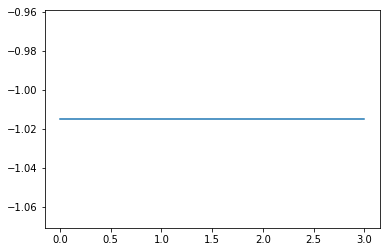

In [13]:
plt.plot(result)